In [6]:
from google.colab import drive
import nbformat

drive.mount('/content/drive')
path = "/content/drive/MyDrive/Colab Notebooks/FineTuningWav2VecTiengViet.ipynb"

with open(path, "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

if "widgets" not in nb['metadata']:
    nb['metadata']["widgets"] = {"state": {}, "version": "1.1.4"}
else:
    if "state" not in nb['metadata']["widgets"]:
        nb['metadata']["widgets"]["state"] = {}
    if "version" not in nb['metadata']["widgets"]:
        nb['metadata']["widgets"]["version"] = "1.1.4"

with open(path, "w", encoding="utf-8") as f:
    nbformat.write(nb, f)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install datasets jiwer  torchaudio
! pip install -U accelerate
! pip install -U transformers

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
from datasets import load_dataset, load_metric, Audio
import IPython.display as ipd
import numpy as np
import random
from datasets import ClassLabel
import pandas as pd
from IPython.display import display, HTML

In [ ]:
ds_train = load_dataset("mozilla-foundation/common_voice_11_0", "vi", split="train+test")
ds_test = load_dataset("mozilla-foundation/common_voice_11_0",
                       "vi", split="validation")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for mozilla-foundation/common_voice_11_0 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mozilla-foundation/common_voice_11_0.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split: 0 examples [00:00, ? examples/s]


Reading metadata...: 2525it [00:00, 53522.84it/s]


Generating validation split: 0 examples [00:00, ? examples/s]


Reading metadata...: 248it [00:00, 51407.90it/s]


Generating test split: 0 examples [00:00, ? examples/s]


Reading metadata...: 1237it [00:00, 121800.93it/s]


Generating other split: 0 examples [00:00, ? examples/s]


Reading metadata...: 11476it [00:00, 119656.73it/s]


Generating invalidated split: 0 examples [00:00, ? examples/s]


Reading metadata...: 337it [00:00, 71279.90it/s]


In [ ]:
ds_test[2]

{'client_id': 'c29d07b14c1806169f49b175b3bc29a620bd2d4c2291a4f8ecbe7dfbaf53fb40f990ebe6617dd1c281d09718ffab9a69d2fb615d19ba084288ba13d134253426',
 'path': '/root/.cache/huggingface/datasets/downloads/extracted/c0bd741c09013def6d06ad13cf55cc288939b3762f228993f8794fb260c3e396/vi_dev_0/common_voice_vi_25222863.mp3',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/c0bd741c09013def6d06ad13cf55cc288939b3762f228993f8794fb260c3e396/vi_dev_0/common_voice_vi_25222863.mp3',
  'array': array([0., 0., 0., ..., 0., 0., 0.]),
  'sampling_rate': 48000},
 'sentence': 'Apheng l·∫•y qu·∫°t tay cho√†ng n√≥, n√≥ li·ªÅn h·ªèi',
 'up_votes': 2,
 'down_votes': 0,
 'age': '',
 'gender': '',
 'accent': '',
 'locale': 'vi',
 'segment': ''}

In [ ]:
print(ds_train)
print(ds_test)

Dataset({
    features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
    num_rows: 3762
})
Dataset({
    features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
    num_rows: 248
})


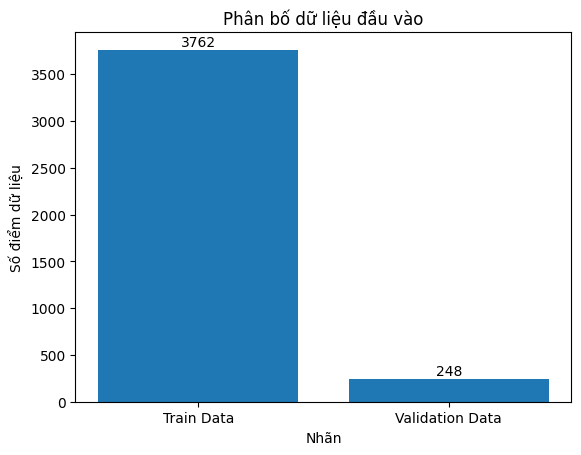

In [ ]:
import matplotlib.pyplot as plt
data = [ds_train.num_rows, ds_test.num_rows]
labels = ['Train Data', 'Validation Data']
plt.bar(labels, data)
plt.xlabel('Nh√£n')
plt.ylabel('S·ªë ƒëi·ªÉm d·ªØ li·ªáu')
plt.title('Ph√¢n b·ªë d·ªØ li·ªáu ƒë·∫ßu v√†o')
for index, value in enumerate(data):
  plt.text(index, value, str(value), ha = 'center', va = 'bottom')
plt.show()



In [ ]:
#Lo·∫°i b·ªè c√°c ph·∫ßn kh√¥ng c·∫ßn thi·∫øt ·ªü trong data
ds_train = ds_train.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes"])
ds_test = ds_test.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes"])

In [ ]:
#t·∫°o c√°c s·ªë ng·∫´u nhi√™n ƒë·ªÉ l·∫•y ra c√°c d·ªØ li·ªáu ng·∫´u nhi√™n ·ªü trong dataset
def show_random_elements(dataset, num_examples=10):
  assert num_examples <= len(dataset)
  picks = []
  for _ in range(num_examples):
    pick = random.randint(0, len(dataset)-1)
    while pick in picks:
      pick = random.randint(0, len(dataset) - 1)
    picks.append(pick)

  df = pd.DataFrame(dataset[picks])
  display(HTML(df.to_html()))


In [ ]:
show_random_elements(ds_train.remove_columns(["path", "audio"]), num_examples=8)

In [ ]:
#x√≥a c√°c k√≠ t·ª± ƒë·∫∑c bi·ªát
import re #Th∆∞ vi·ªán ƒë·ªÉ s·ª≠ d·ª•ng c√°c bi·ªÉu th·ª©c ch√≠nh quy
chars_to_ignore = '[\,\?\.\!\-\;\:\%\'\"\ÔøΩ\‚Äò]'

def remove_special_chaeacters(batch):
  batch["sentence"] = re.sub(chars_to_ignore, '', batch["sentence"]).lower() + " "
  return batch

In [ ]:
ds_train = ds_train.map(remove_special_chaeacters)
ds_test = ds_test.map(remove_special_chaeacters)


Map:   0%|          | 0/3762 [00:00<?, ? examples/s]

Map:   0%|          | 0/248 [00:00<?, ? examples/s]

In [ ]:
show_random_elements(ds_train.remove_columns(['path', 'audio']))

In [ ]:
#Chuy·ªÉn audio v·ªÅ rate 16khz
ds_train = ds_train.cast_column("audio", Audio(sampling_rate=16_000))
ds_test = ds_test.cast_column("audio", Audio(sampling_rate=16_000))

In [ ]:
rand_int = random.randint(0, len(ds_train) - 1)
print(ds_train[rand_int]["sentence"])
ipd.Audio(data = ds_train[rand_int]["audio"]["array"], autoplay = False, rate = 16000)

con thanh nh√† m√¨nh b·ªã ma qu·ª∑ qu·∫•y ph√° 


In [ ]:
print("Target text:", ds_train[rand_int]["sentence"])
print("Input array shape:", ds_train[rand_int]["audio"]["array"].shape)
print("Sampling rate:", ds_train[rand_int]["audio"]["sampling_rate"])

Target text: con thanh nh√† m√¨nh b·ªã ma qu·ª∑ qu·∫•y ph√° 
Input array shape: (97536,)
Sampling rate: 16000


T·∫†O B·ªò TOKENIZER


In [ ]:
def extract_all_chars(batch):
  all_text = " ".join(batch["sentence"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

In [ ]:
vocab_train = ds_train.map(
  extract_all_chars, batched=True,
  batch_size=-1, keep_in_memory=True,
  remove_columns=ds_train.column_names
)
vocab_test = ds_test.map(
  extract_all_chars, batched=True,
  batch_size=-1, keep_in_memory=True,
  remove_columns=ds_test.column_names
)

Map:   0%|          | 0/3762 [00:00<?, ? examples/s]

Map:   0%|          | 0/248 [00:00<?, ? examples/s]

In [ ]:
vocab_list = list(set(vocab_train["vocab"][0]) | set(vocab_test["vocab"][0]))


In [ ]:
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
vocab_dict

{'·ª±': 0,
 '·ªù': 1,
 '·ª∑': 2,
 'b': 3,
 'ƒë': 4,
 '·ª©': 5,
 'g': 6,
 '·∫©': 7,
 '·ªµ': 8,
 'z': 9,
 '∆∞': 10,
 'r': 11,
 '√™': 12,
 '·ªô': 13,
 '√®': 14,
 '·∫ß': 15,
 'ƒÉ': 16,
 '·∫´': 17,
 '√¨': 18,
 '·ª≠': 19,
 '·ªâ': 20,
 'k': 21,
 't': 22,
 's': 23,
 '·∫≠': 24,
 '·ªÅ': 25,
 'x': 26,
 '√π': 27,
 '·ªç': 28,
 '·ªü': 29,
 '·∫£': 30,
 'a': 31,
 '·∫±': 32,
 '√≤': 33,
 '·∫°': 34,
 '·ªè': 35,
 'i': 36,
 'd': 37,
 '·ªõ': 38,
 '√µ': 39,
 '√£': 40,
 ' ': 41,
 'e': 42,
 '·ªß': 43,
 '·∫•': 44,
 '·ªï': 45,
 'o': 46,
 '·ªÉ': 47,
 'l': 48,
 'n': 49,
 '√†': 50,
 '·∫Ø': 51,
 '√©': 52,
 '√¥': 53,
 'h': 54,
 '√¢': 55,
 'v': 56,
 '√≥': 57,
 '·ªØ': 58,
 '·∫ª': 59,
 'p': 60,
 '·ªó': 61,
 '√≠': 62,
 '·ªì': 63,
 '·∫ø': 64,
 '·ªã': 65,
 '·∫Ω': 66,
 '·∫∑': 67,
 'y': 68,
 '≈©': 69,
 'f': 70,
 'u': 71,
 '·ªë': 72,
 '·ª´': 73,
 'q': 74,
 '√∫': 75,
 '·ª•': 76,
 '√°': 77,
 '√Ω': 78,
 '·∫π': 79,
 '·ªÖ': 80,
 '·ª£': 81,
 'm': 82,
 '·∫µ': 83,
 '·ªá': 84,
 'w': 85,
 'ƒ©': 86,
 '∆°': 87,
 '·∫≥': 88,
 '·ª°': 89,
 '

In [ ]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [ ]:
# Th√™m [UNK] cho t·ª´ kh√¥ng x√°c ƒë·ªãnh
vocab_dict["[UNK]"] = len(vocab_dict)
# Th√™m [PAD] ƒë·ªÉ padding cho c√πng chi·ªÅu d√†i input
vocab_dict["[PAD]"] = len(vocab_dict)
# In chi·ªÅu d√†i t·ª´ ƒëi·ªÉn
len(vocab_dict)

96

In [ ]:
import json
with open('vocab.json', 'w') as vocab_file:
  json.dump(vocab_dict, vocab_file)

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
model_wav2vec2 = "facebook/wav2vec2-large-xlsr-53"
model_checkpoint = "HaKhoa/wav2vec2-vi"

In [ ]:
from transformers import AutoConfig
config = AutoConfig.from_pretrained(model_wav2vec2)
tokenizer_type = config.model_type if config.tokenizer_class is None else None
config = config if config.tokenizer_class is not None else None

config.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

In [ ]:
from transformers import Wav2Vec2CTCTokenizer
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained(
  "./",
  config=config,
  tokenizer_type=tokenizer_type,
  unk_token="[UNK]",
  pad_token="[PAD]",
  word_delimiter_token="|",
)
# tokenizer.push_to_hub(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
from transformers import Wav2Vec2CTCTokenizer
# Load tokenizer t·ª´ hub ƒë√£ l∆∞u ·ªü tr√™n
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained(
  model_checkpoint,
  config=config,
  tokenizer_type=tokenizer_type,
  unk_token="[UNK]",
  pad_token="[PAD]",
  word_delimiter_token="|",
)

tokenizer_config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/30.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

In [ ]:
tokenizer

Wav2Vec2CTCTokenizer(name_or_path='HaKhoa/wav2vec2-vi', vocab_size=96, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '[UNK]', 'pad_token': '[PAD]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	94: AddedToken("[UNK]", rstrip=True, lstrip=True, single_word=False, normalized=False, special=False),
	95: AddedToken("[PAD]", rstrip=True, lstrip=True, single_word=False, normalized=False, special=False),
	96: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	97: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
from transformers import Wav2Vec2FeatureExtractor
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_wav2vec2)

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

In [ ]:
feature_extractor


Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0,
  "return_attention_mask": true,
  "sampling_rate": 16000
}

In [ ]:
from transformers import Wav2Vec2Processor
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [ ]:
# H√†m map processor l√™n audio v√† nh√£n c·ªßa t·ª´ng ƒëi·ªÉm d·ªØ li·ªáu tr√™n t·∫≠p
def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched"
    batch["input_values"] = processor(audio["array"],
                                      sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])

    with processor.as_target_processor():
        batch["labels"] = processor(batch["sentence"]).input_ids
    return batch

In [ ]:
ds_train = ds_train.map(prepare_dataset, remove_columns=ds_train.column_names)
ds_test = ds_test.map(prepare_dataset, remove_columns=ds_test.column_names)

Map:   0%|          | 0/3762 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/248 [00:00<?, ? examples/s]

In [ ]:
# ƒê·∫∑t ƒë·ªô d√†i t·ªëi ƒëa ƒë·∫ßu v√†o l√† 15s
max_input_length_in_sec = 15.0
ds_train = ds_train.filter(lambda x: x < max_input_length_in_sec * processor.feature_extractor.sampling_rate,
                           input_columns=["input_length"])
ds_test = ds_test.filter(lambda x: x < max_input_length_in_sec * processor.feature_extractor.sampling_rate,
                          input_columns=["input_length"])

Filter:   0%|          | 0/3762 [00:00<?, ? examples/s]

Filter:   0%|          | 0/248 [00:00<?, ? examples/s]

In [ ]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
@dataclass
class DataCollatorCTCWithPadding:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # thay th·∫ø ph·∫ßn pad b·∫±ng -100 ƒë·ªÉ b·ªè qua loss m·ªôt c√°ch ch√≠nh x√°c
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch


In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [ ]:
wer_metric = load_metric("wer")

<ipython-input-37-605de035dfd7>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library ü§ó Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")


The repository for wer contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/wer.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [ ]:
# H√†m t√≠nh ch·ªâ s·ªë wer tr√™n t·∫≠p validation
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # Kh√¥ng nh√≥m c√°c tokens (group_tokens) khi t√≠nh metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [ ]:
from transformers import AutoModelForCTC
# T·∫£i model wav2vec2 g·ªëc
model = AutoModelForCTC.from_pretrained(
    model_wav2vec2,
    attention_dropout=0.1,
    hidden_dropout=0.1,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.1,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
).to("cuda")

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['lm_head.bias', 'lm_head.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
if hasattr(model, "freeze_feature_extractor"):
  model.freeze_feature_extractor()

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:2177: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5. Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="wav2vec_vietnamese",
  group_by_length=True,
  per_device_train_batch_size=30,
  gradient_accumulation_steps=2,
  evaluation_strategy="steps",
  num_train_epochs=7,
  gradient_checkpointing=True,
  save_steps=50,
  eval_steps=50,
  logging_steps=50,
  learning_rate=3e-4,
  save_total_limit=2,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ü§ó Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=ds_train,
    eval_dataset=ds_test,
    tokenizer=processor.feature_extractor,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of 

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of 

In [ ]:

trainer.evaluate()

In [ ]:
training_loss,validation_loss=[],[]
validation_wer=[]
t = 0
for i in trainer.state.log_history[:-2]:
   if t == 0:
     training_loss.append(i["loss"])
     t=1
   else:
     validation_loss.append(i["eval_loss"])
     validation_wer.append(i["eval_wer"])
     t=0
from matplotlib import pyplot as plt
plt.plot(training_loss, label='train_loss')
plt.plot(validation_loss,label='val_loss')
plt.plot(validation_wer,label='eval_wer')
plt.legend()
plt.show

In [ ]:
repo_name = "HaKhoa/wav2vec2-vi"
model.push_to_hub(repo_name)

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="wav2vec_vietnamese",
    group_by_length=True,
    per_device_train_batch_size=30,
    gradient_accumulation_steps=2,
    evaluation_strategy="steps",
    num_train_epochs=7,
    gradient_checkpointing=True,
    save_steps=50,
    eval_steps=50,
    logging_steps=50,
    learning_rate=3e-4,
    save_total_limit=2,
    resume_from_checkpoint=True  # This will automatically find the last checkpoint
)

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=ds_train,
    eval_dataset=ds_test,
    tokenizer=processor.feature_extractor,
)

trainer.train()
